# Imports

In [357]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,precision_score, recall_score,roc_curve, roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Flatten, Embedding, LSTM, GRU, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

tfidf = TfidfVectorizer(ngram_range=(2,2))
sid = SentimentIntensityAnalyzer()
lb = LabelBinarizer()
lemmatizer = WordNetLemmatizer()




# Helper functions/classes

In [127]:
class WordCloudGeneration:
    def preprocessing(self, data):
        data = data.split(".")
        # convert all words to lowercase
        data = [item.lower() for item in data]
        # load the stop_words of english
        stop_words = set(stopwords.words('english'))
        # concatenate all the data with spaces.
        paragraph = ' '.join(data)
        # tokenize the paragraph using the inbuilt tokenizer
        word_tokens = word_tokenize(paragraph) 
        # filter words present in stopwords list 
        preprocessed_data = ' '.join([word for word in word_tokens if not word in stop_words])
        return preprocessed_data

    def create_word_cloud(self, final_data,title=""):
        final_data=self.preprocessing(final_data)

        wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="white").generate(final_data)
        plt.figure(figsize=(12,10))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(title,fontsize=40)
        plt.show()

        
wordcloud_generator = WordCloudGeneration()

In [317]:
def show_metrics(true_vals,pred_vals):
    print(pd.DataFrame(confusion_matrix(true_vals,pred_vals),columns=["negative","neutral","positive"],index=["negative","neutral","positive"]))
    print("\n")
    print(classification_report(true_vals,pred_vals))
    show_roc(true_vals,pred_vals)

def show_roc(y_val,y_pred):
    lb.fit(y_val)
    y_val1 = lb.transform(y_val)
    y_pred1 = lb.transform(y_pred)
    print(f"WEIGHTED_ROC_AUC_SCORE: {roc_auc_score(y_val1, y_pred1, average='weighted'):.3f}")
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    lw=2
    for i in range(3):
        plt.plot(fpr[i], tpr[i], lw=lw,
                label='ROC curve of class Model (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of current Model')
    plt.legend(loc="lower right")
    plt.show()
    
def to_labels(series):
  le=LabelEncoder()
  return le.fit_transform(series)

def get_sentiment_scores(df):
    print("Calclating Polarity Scores - Reviews.text")
    df["reviews.text_scores"] = np.array(df["reviews.text"].map(lambda x: sid.polarity_scores(x)))
    print("Calclating Polarity Scores - Reviews.titl")
    df["reviews.title_scores"] = np.array(df["reviews.title"].map(lambda x: sid.polarity_scores(x)))
    neg=[]
    neu=[]
    pos=[]
    for scores in df["reviews.text_scores"]:
        neg.append(scores["neg"])
        neu.append(scores["neu"])
        pos.append(scores["pos"])
    df["reviews_text_neg"] = np.array(neg)
    df["reviews_text_neu"] = np.array(neu)
    df["reviews_text_pos"] = np.array(pos)
    df.drop(["reviews.text_scores","reviews.title_scores"],axis=1,inplace=True)
    
    print("Calclating Polarity Scores - Complete")

def get_tfidf(reviews):
    reviews_tfidf_Vect =tfidf.fit(reviews)
    feature_names = reviews_tfidf_Vect.get_feature_names()
    reviews_tfidf_dtm =tfidf.transform(reviews)
    reviews_tfidf_dtm_df =pd.DataFrame(reviews_tfidf_dtm.toarray(),columns=feature_names)

    return reviews_tfidf_dtm_df

def clean_data(reviews):
    #deal with casing
    reviews = reviews.apply(lambda x:x.lower())

    #used regex to remove URLS
    URLpattern = "(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*"
    reviews = reviews.apply(lambda x:re.sub(URLpattern,"",x))

    #remove hash symbols
    reviews = reviews.apply(lambda x:re.sub("#","",x))

    #remove extra '....'
    reviews = reviews.apply(lambda x:re.sub("\.+","",x))

    #remove anomolies
    anomolies =[
        "äî",
        "äú",
        "äù",
        "äô",
        "äã",
        "äò"
        
    ]
    for anomoly in anomolies:
        reviews = reviews.apply(lambda x:re.sub(anomoly," ",x))
        
    #tokenize
    reviews = reviews.apply(word_tokenize)

    reviews = reviews.apply(lambda x:[word for word in x if word not in stop_words and len(word)>1 and word not in string.punctuation])


    #rejoin tokens into text

    reviews = reviews.apply(lambda x:" ".join(x))
    return reviews


# EDA

In [318]:
train_df = pd.read_csv("..\Datasets\Ecommerce\\train_data.csv")
test_df = pd.read_csv("..\Datasets\Ecommerce\\test_data.csv")
test_val_df = pd.read_csv("..\Datasets\Ecommerce\\test_data_hidden.csv")

In [319]:
train_df.duplicated().sum(), test_df.duplicated().sum(), test_val_df.duplicated().sum()

(58, 3, 3)

**Found existing duplicate data**

In [320]:
train_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,3990,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,Got this for my Daughter-in-Law and she loves ...,Great tablet,Positive
freq,676,4000,628,2600,99,4,100,3749


In [321]:
train_df.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

In [322]:
test_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [323]:
test_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,1000,1000,1000,1000,1000,1000,997
unique,23,1,23,4,366,979,796
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this for my daughter. It's a little l...,Great tablet
freq,169,1000,169,676,26,2,22


In [324]:
test_val_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive


In [325]:
test_val_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,1000,1000,1000,1000,1000,1000,997,1000
unique,23,1,23,4,366,979,796,3
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this for my daughter. It's a little l...,Great tablet,Positive
freq,169,1000,169,676,26,2,22,937


In [326]:
train_df.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [327]:
test_df.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        3
dtype: int64

**Null values found in reviews.title   -  Fill  with empty string**

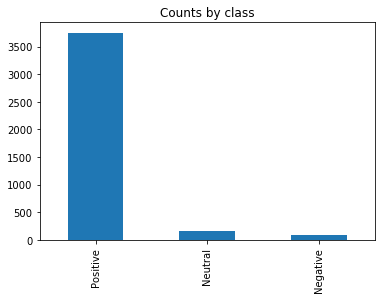

In [328]:
train_df["sentiment"].value_counts().plot(kind="bar", title="Counts by class")

**Class Imbalance Problem - Will try oversampling and classweights**

In [329]:
Positive_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Positive"]["reviews.text"]:
  Positive_Review_Text += " " +review.lower()

Negative_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Negative"]["reviews.text"]:
  Negative_Review_Text += " " +review.lower()

Neutral_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Neutral"]["reviews.text"]:
  Neutral_Review_Text += " " +review.lower()


# Wordclouds

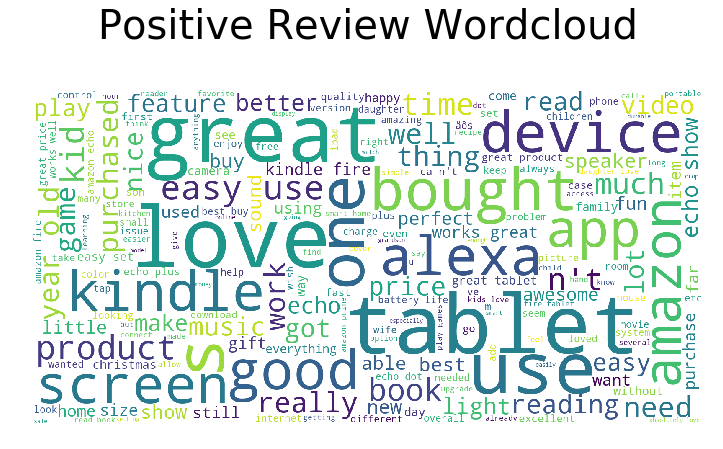

In [330]:

wordcloud_generator.create_word_cloud(Positive_Review_Text,"Positive Review Wordcloud\n")

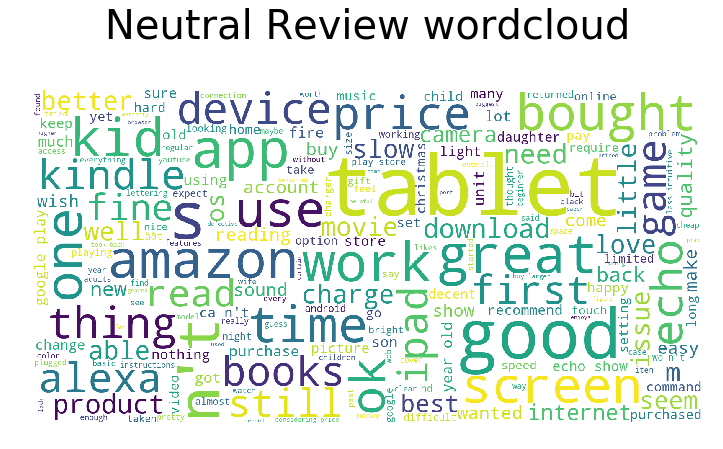

In [331]:
wordcloud_generator.create_word_cloud(Neutral_Review_Text,"Neutral Review wordcloud\n")

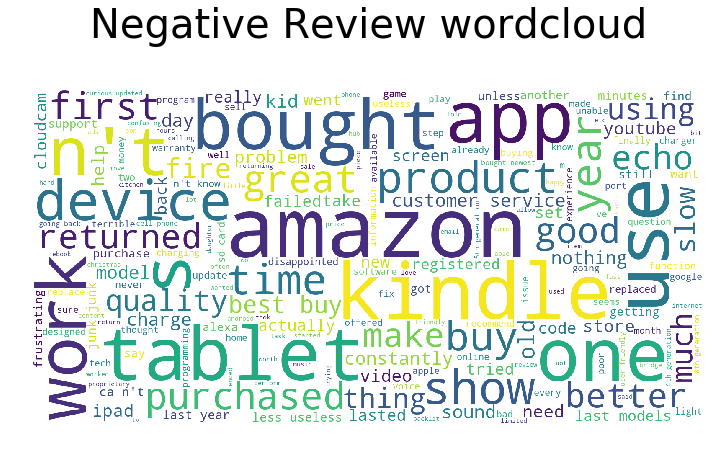

In [332]:
wordcloud_generator.create_word_cloud(Negative_Review_Text,"Negative Review wordcloud\n")

# Observations 

Duplicates found in all datasets
**Drop Duplicates**

**Will drop all columns except text and title**

Sentiment is categorical:
**LabelEncoder**

reviews.text and reviews.title are text:
**TFIDF**
**Sentiment Analysis**

null values in reviews.title:
**fill null value with " "**

class imbalance issue:
**oversampling**
**class weights**



# Tasks based on observations

Remove Duplicates

In [333]:
train_df=train_df[train_df.duplicated()==False]
test_df=test_df[test_df.duplicated()==False]
test_val_df=test_val_df[test_val_df.duplicated()==False]

train_df.reset_index(inplace=True)
test_val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

fill null values

In [334]:
train_df['reviews.title'].fillna(value='',inplace=True)
test_val_df['reviews.title'].fillna(value=' ',inplace=True)
test_df['reviews.title'].fillna(value=' ',inplace=True)

Keep only desired columns

In [335]:
train_df=train_df[["reviews.text","reviews.title","sentiment"]]
test_df=test_df[["reviews.text","reviews.title"]]
test_val_df=test_val_df[["reviews.text","reviews.title","sentiment"]]

# Processing Data

Encode categories

In [336]:


  train_df["sentiment"]=to_labels(train_df["sentiment"])
  test_val_df["sentiment"]=to_labels(test_val_df["sentiment"])


train_df.shape,test_df.shape,test_val_df.shape

((3942, 3), (997, 2), (997, 3))

In [337]:
train_df.head()

,reviews.text,reviews.title,sentiment
0,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,2
1,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,2
2,Just an average Alexa option. Does show a few ...,Average,1
3,"very good product. Exactly what I wanted, and ...",Greattttttt,2
4,This is the 3rd one I've purchased. I've bough...,Very durable!,2


In [338]:
review_text_train = train_df["reviews.text"]
review_text_test = test_df["reviews.text"]

In [339]:
review_title_train = train_df["reviews.text"]
review_title_test = test_df["reviews.text"]

In [340]:
stop_words = stopwords.words("english")

In [341]:
train_df["reviews.text"] = clean_data(review_text_train)
train_df["reviews.title"] = clean_data(review_title_train)
test_df["reviews.text"] = clean_data(review_text_test)
test_df["reviews.title"] = clean_data(review_title_test)
test_val_df["reviews.text"] = clean_data(review_text_test)
test_val_df["reviews.title"] = clean_data(review_title_test)

In [342]:
train_df

,reviews.text,reviews.title,sentiment
0,purchased black fridaypros great price even sa...,purchased black fridaypros great price even sa...,2
1,purchased two amazon echo plus two dots plus f...,purchased two amazon echo plus two dots plus f...,2
2,average alexa option show things screen still ...,average alexa option show things screen still ...,1
3,good product exactly wanted good price,good product exactly wanted good price,2
4,3rd one 've purchased 've bought one nieces ca...,3rd one 've purchased 've bought one nieces ca...,2
...,...,...,...
3937,it‚ fun family play may get boring newness wea...,it‚ fun family play may get boring newness wea...,2
3938,love kindle great product reduces eye strain e...,love kindle great product reduces eye strain e...,2
3939,looking blutooth speaker use phone n't want wo...,looking blutooth speaker use phone n't want wo...,2
3940,second amazon fire tablet purchased time color...,second amazon fire tablet purchased time color...,2


Vectorize text with Tfidf

In [362]:
# get_sentiment_scores(train_df)
# get_sentiment_scores(test_df)
# get_sentiment_scores(test_val_df)

train_text_tfidf_df = get_tfidf(review_text_train)
train_title_tfidf_df = get_tfidf(review_title_train)
test_text_tfidf_df = get_tfidf(review_text_test)
test_title_tfidf_df = get_tfidf(review_title_test)

y_train = train_df["sentiment"]
y_test = test_val_df["sentiment"]

sm=SMOTE()
X_over,y_over=sm.fit_resample(train_text_tfidf_df,y_train)



In [363]:
X_train,X_test,y_train,y_test = train_test_split(X_over,y_over, test_size=.2,random_state=1)

# Multinomial Naive Bayes Classification


In [364]:
model = MultinomialNB()

          negative  neutral  positive
negative       720        0         0
neutral          0      748         0
positive        18       22       709


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       720
           1       0.97      1.00      0.99       748
           2       1.00      0.95      0.97       749

    accuracy                           0.98      2217
   macro avg       0.98      0.98      0.98      2217
weighted avg       0.98      0.98      0.98      2217

WEIGHTED_ROC_AUC_SCORE: 0.986


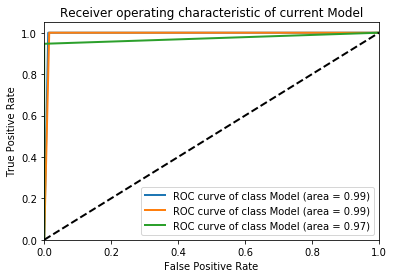

In [365]:
model.fit(X_train,y_train)
preds=model.predict(X_test)
show_metrics(y_test,preds)

### Using only sentiment data seems to possibly make the model more discriminent

# Trying models with oversampled/undersampled data

### Defining Models to test

In [373]:
models=[
        RandomForestClassifier(class_weight='balanced'),
        XGBClassifier(use_label_encoder=False, n_estimators=5,n_jobs=-1)
        ]


## Testing Models

Using only base models with class_weights to start

Using ROC_AUC Score as defining metric

### Control Group with sentiment scores

RandomForestClassifier(class_weight='balanced') 
 ************************************************** 

          negative  neutral  positive
negative       720        0         0
neutral          0      748         0
positive         0        0       749


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       720
           1       1.00      1.00      1.00       748
           2       1.00      1.00      1.00       749

    accuracy                           1.00      2217
   macro avg       1.00      1.00      1.00      2217
weighted avg       1.00      1.00      1.00      2217

WEIGHTED_ROC_AUC_SCORE: 1.000


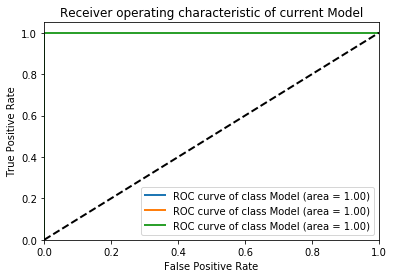

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=-1, num_parallel_tree=None, predictor=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None) 
 ************************************************** 

[16:00:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like 

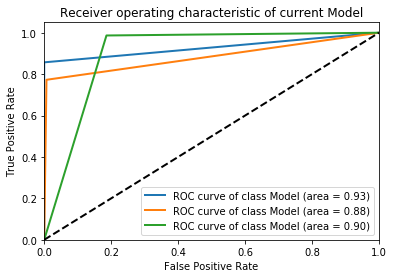

In [374]:
for model in models:
    print(model,"\n","*"*50,"\n")

    model.fit(X_over,y_over)
    preds = model.predict(X_test)
    show_metrics(y_test,preds)

# Simple ANN

In [375]:

es=EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=2,
    mode='auto',
    baseline=None,
    restore_best_weights=True,)
y_train2 = label_binarize(y_over, classes=[0, 1, 2])    
y_test2 = label_binarize(y_test, classes=[0, 1, 2])    


In [376]:
NN= Sequential()
NN.add(Flatten())
NN.add(Dense(64, activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(128,activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(256,activation="relu"))

NN.add(Dropout(.4))
NN.add(Dense(3,activation="softmax"))
NN.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc"])

In [378]:

NN.fit(X_over,y_train2,epochs=100, validation_data=[X_test,y_test2],callbacks=[es])

Epoch 1/100
347/347 [==============================] - 16s 23ms/step - loss: 0.1792 - acc: 0.9233 - val_loss: 0.0027 - val_acc: 0.9991
Epoch 2/100
347/347 [==============================] - 6s 17ms/step - loss: 0.0023 - acc: 0.9994 - val_loss: 1.9169e-05 - val_acc: 1.0000
Epoch 3/100
347/347 [==============================] - 6s 17ms/step - loss: 3.3467e-04 - acc: 1.0000 - val_loss: 1.3491e-06 - val_acc: 1.0000
Epoch 4/100
347/347 [==============================] - 6s 17ms/step - loss: 2.7801e-04 - acc: 0.9999 - val_loss: 1.0701e-06 - val_acc: 1.0000
Epoch 5/100
347/347 [==============================] - 6s 18ms/step - loss: 5.3021e-05 - acc: 1.0000 - val_loss: 2.9885e-07 - val_acc: 1.0000
Epoch 6/100
347/347 [==============================] - 7s 19ms/step - loss: 3.7000e-04 - acc: 0.9998 - val_loss: 1.6949e-06 - val_acc: 1.0000
Epoch 7/100
347/347 [==============================] - 6s 18ms/step - loss: 7.2811e-05 - acc: 1.0000 - val_loss: 1.8282e-07 - val_acc: 1.0000
Epoch 8/100
347/3

In [379]:
preds_array = NN.predict(X_test)
pred_list = []
for i,pred in enumerate(preds_array):
    pred_list.append(pred.argmax())

          negative  neutral  positive
negative       720        0         0
neutral          0      748         0
positive         0        0       749


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       720
           1       1.00      1.00      1.00       748
           2       1.00      1.00      1.00       749

    accuracy                           1.00      2217
   macro avg       1.00      1.00      1.00      2217
weighted avg       1.00      1.00      1.00      2217

WEIGHTED_ROC_AUC_SCORE: 1.000


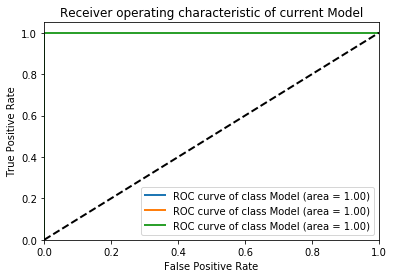

In [380]:
show_metrics(y_test,pred_list)

# Using LSTM to predict classes

In [382]:

y_train2 = label_binarize(y_over, classes=[0, 1, 2])
y_test2 = label_binarize(y_test, classes=[0,1,2])
epochs = 10
emb_dim = 64
batch_size = 64
layers=4
do=.5
rdo=.5
num_cells=4



In [383]:
earlystopping=EarlyStopping(
  monitor="val_auc",
  patience=2,
  mode="max",
  restore_best_weights=True
)

In [ ]:
model = Sequential()
model.add(Embedding(X_over.shape[0], emb_dim, input_length=X_over.shape[1]))
model.add(LSTM(layers, dropout=do, recurrent_dropout=rdo))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc","AUC"])

In [386]:
model.fit(X_over, y_train2, epochs=epochs,batch_size=batch_size, validation_data=[X_test,y_test2],use_multiprocessing=True, workers=4, callbacks=[earlystopping])


Epoch 1/10
  1/174 [..............................] - ETA: 44:49:56 - loss: 1.0971 - acc: 0.3594 - auc: 0.5164

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)

NotFittedError: need to call fit or load_model beforehand

# Using GRU to predict classes

In [ ]:
model = Sequential()
model.add(Embedding(X.shape[0], emb_dim, input_length=X.shape[1]))
model.add(GRU(layers, dropout=do, recurrent_dropout=rdo))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc","AUC"])


In [224]:
model.fit(
  X, 
  y_train2, 
  epochs=epochs, 
  batch_size=batch_size,
  validation_data=[sent_test,y_test2],
  use_multiprocessing=True, 
  workers=4,
  callbacks=[earlystopping])
preds = model.predict(sent_test, batch_size=100)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)


Epoch 1/10
5/5 [==============================] - 39s 5s/step - loss: 8.4674 - acc: 0.3593 - auc: 0.5377 - val_loss: 1.1338 - val_acc: 0.0241 - val_auc: 0.0436
Epoch 2/10
5/5 [==============================] - 21s 4s/step - loss: 8.3106 - acc: 0.3333 - auc: 0.4855 - val_loss: 1.1751 - val_acc: 0.0241 - val_auc: 0.0436
Epoch 3/10
5/5 [==============================] - 21s 5s/step - loss: 8.1062 - acc: 0.3481 - auc: 0.4939 - val_loss: 1.2224 - val_acc: 0.0241 - val_auc: 0.0437
Epoch 4/10
5/5 [==============================] - 21s 4s/step - loss: 7.9461 - acc: 0.3407 - auc: 0.4930 - val_loss: 1.2749 - val_acc: 0.0241 - val_auc: 0.0437
Epoch 5/10
5/5 [==============================] - 21s 4s/step - loss: 7.8039 - acc: 0.3519 - auc: 0.4946 - val_loss: 1.3324 - val_acc: 0.0241 - val_auc: 0.0436
Epoch 6/10
5/5 [==============================] - 21s 5s/step - loss: 7.6758 - acc: 0.3370 - auc: 0.4960 - val_loss: 1.3913 - val_acc: 0.0241 - val_auc: 0.0436
Epoch 7/10
5/5 [========================

ValueError: in user code:

    File "C:\Users\perry\.conda\envs\nlp_course_2\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\perry\.conda\envs\nlp_course_2\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\perry\.conda\envs\nlp_course_2\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\perry\.conda\envs\nlp_course_2\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\perry\.conda\envs\nlp_course_2\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\perry\.conda\envs\nlp_course_2\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_24" is incompatible with the layer: expected shape=(None, 1003), found shape=(None, 1009)


# Finetuning LSTM/GRU with keras-tuner

# Topic Modeling